# Prep data

In [1]:
import sys
import time
from os import listdir
import gzip

from collections import Counter, Hashable, defaultdict
from itertools import chain, product

import numpy as np
from scipy import sparse
import random

In [2]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}

In [3]:
chrom = '22'
m = 4
ped_file = '../data/160826.ped'
data_dir = '../split_gen_miss'
# out_dir = sys.argv[5]
batch_size = None
batch_num = None
batch_offset = None

error_rate = .02
smooth = 5000
chrom_length = chrom_lengths[chrom]

# genotype (pred, obs): cost
g_cost = {
	(-1, -1): 0,
	(-1, 0): 1,
	(-1, 1): 1,
	(-1, 2): 1,
	(0, -1): 0,
	(0, 0): 0,
	(0, 1): 1,
	(0, 2): 2,
	(1, -1): 0,
	(1, 0): 1,
	(1, 1): 0,
	(1, 2): 1,
	(2, -1): 0,
	(2, 0): 2,
	(2, 1): 1,
	(2, 2): 0
}

shift_costs = [10]*4 + [500]*(2*(m-2))

In [4]:
# set up filenames
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])

#fam_output_file = '%s/chr.%s.familysize.%s.families.txt' % (out_dir, chrom, m)
#phase_output_file = '%s/chr.%s.familysize.%s.phased.txt' % (out_dir, chrom, m)

# adapt to batch_size
if batch_size is not None:
	batch_offset = batch_size*batch_num
	#fam_output_file = fam_output_file[:-4] + str(batch_num) + '.txt'
	#phase_output_file = phase_output_file[:-4] + str(batch_num) + '.txt'

In [8]:
def pull_families(sample_file, batch_size=None, batch_offset=None):
	# pull families with sequence data
	with open(sample_file, 'r') as f:
		sample_ids = [line.strip() for line in f]

	# pull families from ped file
	families = dict()
	with open(ped_file, 'r') as f:	
	    for line in f:
	        pieces = line.strip().split('\t')
	        fam_id, child_id, f_id, m_id = pieces[0:4]

	        if child_id in sample_ids and f_id in sample_ids and m_id in sample_ids:
	        	if (fam_id, m_id, f_id) not in families:
	        		families[(fam_id, m_id, f_id)] = [m_id, f_id]
	        	families[(fam_id, m_id, f_id)].append(child_id)

	# randomly permute children
	families = dict([(k, x[:2]+random.sample(x[2:], len(x)-2)) for k, x in families.items()])
	print('families with sequence data', len(families))

	families_of_this_size = [(fkey, inds) for fkey, inds in families.items() if len(inds) == m]
	print('families of size %d: %d' % (m, len(families_of_this_size)))

	# limit to batch
	if batch_size is not None:
		family_keys = set(sorted([x[0] for x in families_of_this_size])[batch_offset:(batch_size+batch_offset)])
		families_of_this_size = [(k, v) for k, v in families_of_this_size if k in family_keys]
	
	print('families pulled %d: %d' % (m, len(families_of_this_size)))
	return families_of_this_size

families_of_this_size = pull_families(sample_file, batch_size, batch_offset)

families with sequence data 886
families of size 4: 436
families pulled 4: 436


In [9]:
class InheritanceStates:

	# inheritance states
	#
	# for parents:
	# (0, 1) -> deletion on parental1
	# (1, 0) -> deletion on parental2
	# (1, 1) -> normal
	# 
	# for children:
	# (0, 0) -> m1p1
	# (0, 1) -> m1p2
	# (1, 0) -> m2p1
	# (1, 1) -> m2p2

	def __init__(self, m):
		self.m = m
		if m >= 5:
			self.states = np.array(list(product(*([[0, 1]]*(2*m)))), dtype=np.int8)
		else:
			self.states = np.array([x for x in product(*([[0, 1]]*(2*m))) if x[4]==0 and x[5]==0], dtype=np.int8)
		print('inheritance states', self.states.shape)

		self.p, self.state_len = self.states.shape
		self.state_to_index = dict([(tuple(x), i) for i, x in enumerate(self.states)])

	def __getitem__(self, key):
		return self.states[key]
    
	def index(self, s):
		return self.state_to_index[s]

	def __contains__(self, key):
		return key in self.state_to_index
    
inheritance_states = InheritanceStates(m)

inheritance states (64, 8)


In [10]:
class TransitionMatrix:

	def __init__(self, inheritance_states, shift_costs):

		# transition matrix
		self.shift_costs = shift_costs

		transitions = [[] for i in range(inheritance_states.p)]
		transition_costs = [[] for i in range(inheritance_states.p)]
		for i, state in enumerate(inheritance_states):
			for delstate in list(product(*[[0, 1]]*4)):
				new_state = tuple(delstate) + tuple(state[4:])
				if new_state in inheritance_states:
					new_index = inheritance_states.index(new_state)
					transitions[i].append(new_index)
					transition_costs[i].append(sum([shift_costs[j] for j, (old_s, new_s) in enumerate(zip(state[:4], delstate)) if old_s != new_s]))

			# allow a single recombination event
			for j in range(4, inheritance_states.state_len):
				new_state = tuple(1-x if k == j else x for k, x in enumerate(state))
				if new_state in inheritance_states:
					new_index = inheritance_states.index(new_state)
					transitions[i].append(new_index)
					transition_costs[i].append(shift_costs[j])
		            
		self.transitions = np.array(transitions)
		self.costs = np.array(transition_costs)

		# starting costs
		starting_state = (1, 1, 1, 1, 0, 0)
		self.first_costs = np.zeros((inheritance_states.p,), dtype=int)
		for i, ss in enumerate(starting_state):
			self.first_costs[inheritance_states[:, i] != ss] += shift_costs[i]
		print('transitions', self.transitions.shape)
transition_matrix = TransitionMatrix(inheritance_states, shift_costs)

transitions (64, 18)


In [11]:
class Genotypes:
	def __init__(self, m):
		self.genotypes = np.array(list(product(*[[-1, 0, 1, 2]]*m)), dtype=np.int8)
		self.genotype_to_index = dict([(tuple(x), i) for i, x in enumerate(self.genotypes)])
		self.q = self.genotypes.shape[0]
		print('genotypes', self.genotypes.shape)

	def __getitem__(self, key):
		return self.genotypes[key]

	def index(self, s):
		return self.genotype_to_index[s]

	def __contains__(self, key):
		return key in self.genotype_to_index
    
genotypes = Genotypes(m)

genotypes (256, 4)


In [34]:
class Loss:
	def __init__(self, m, inheritance_states, genotypes, g_cost):
		self.g_cost = g_cost

		self.__build_perfect_matches__(m, inheritance_states)
		self.__build_loss_equivalence__(inheritance_states)

		self.genotypes = genotypes
		self.losses = np.zeros((int(p/4) if m>=5 else inheritance_states.p, genotypes.q), dtype=np.int8)
		self.already_calculated = np.zeros((genotypes.q,), dtype=bool)
		
	def __call__(self, gen): 
		gen_index = genotypes.index(gen)
		if not self.already_calculated[gen_index]:
			s = np.zeros((self.num_pm_gen,), dtype=np.int8)
			for i, pm in enumerate(self.pm_gen):
				s[i] = sum([self.g_cost[(pred, obs)] for pred, obs in zip(pm, gen)])
			    
			for i, indices in enumerate(self.pm_gen_indices):
				self.losses[i, gen_index] = np.min(s[indices])
			self.already_calculated[gen_index] = True
		return self.losses[self.full_loss_indices, gen_index].astype(int)

	def __build_perfect_matches__(self, m, inheritance_states):
		# perfect match genotypes
		pm_gen_to_index = dict()
		self.pm_gen_indices = []
		for s in inheritance_states:
			if s[4] == 0 and s[5] == 0:
				anc_pos = [[-1] if s[i] == 0 else [0, 1] for i in range(4)]
				anc_variants = np.array(list(product(*anc_pos)), dtype=np.int8)
				pred_gens = np.zeros((anc_variants.shape[0], m), dtype=np.int8)

				# mom
				# deletion
				pred_gens[(anc_variants[:, 0]==-1) & (anc_variants[:, 1]==-1), 0] = -1
				pred_gens[(anc_variants[:, 0]==-1) & (anc_variants[:, 1]==0), 0] = 0
				pred_gens[(anc_variants[:, 0]==-1) & (anc_variants[:, 1]==1), 0] = 2
				pred_gens[(anc_variants[:, 0]==0) & (anc_variants[:, 1]==-1), 0] = 0
				pred_gens[(anc_variants[:, 0]==1) & (anc_variants[:, 1]==-1), 0] = 2
				# normal
				pred_gens[(anc_variants[:, 0]==0) & (anc_variants[:, 1]==0), 0] = 0
				pred_gens[(anc_variants[:, 0]==1) & (anc_variants[:, 1]==1), 0] = 2
				pred_gens[(anc_variants[:, 0]==0) & (anc_variants[:, 1]==1), 0] = 1
				pred_gens[(anc_variants[:, 0]==1) & (anc_variants[:, 1]==0), 0] = 1

				# dad
				# deletion
				pred_gens[(anc_variants[:, 2]==-1) & (anc_variants[:, 3]==-1), 1] = -1
				pred_gens[(anc_variants[:, 2]==-1) & (anc_variants[:, 3]==0), 1] = 0
				pred_gens[(anc_variants[:, 2]==-1) & (anc_variants[:, 3]==1), 1] = 2
				pred_gens[(anc_variants[:, 2]==0) & (anc_variants[:, 3]==-1), 1] = 0
				pred_gens[(anc_variants[:, 2]==1) & (anc_variants[:, 3]==-1), 1] = 2
				# normal
				pred_gens[(anc_variants[:, 2]==0) & (anc_variants[:, 3]==0), 1] = 0
				pred_gens[(anc_variants[:, 2]==1) & (anc_variants[:, 3]==1), 1] = 2
				pred_gens[(anc_variants[:, 2]==0) & (anc_variants[:, 3]==1), 1] = 1
				pred_gens[(anc_variants[:, 2]==1) & (anc_variants[:, 3]==0), 1] = 1

				# children
				for index in range(m-2):
					mat, pat = s[(4+(2*index)):(6+(2*index))]

					# deletion
					pred_gens[(anc_variants[:, mat]==-1) & (anc_variants[:, 2+pat]==-1), 2+index] = -1
					pred_gens[(anc_variants[:, mat]==-1) & (anc_variants[:, 2+pat]==0), 2+index] = 0
					pred_gens[(anc_variants[:, mat]==-1) & (anc_variants[:, 2+pat]==1), 2+index] = 2
					pred_gens[(anc_variants[:, mat]==0) & (anc_variants[:, 2+pat]==-1), 2+index] = 0
					pred_gens[(anc_variants[:, mat]==1) & (anc_variants[:, 2+pat]==-1), 2+index] = 2
					# normal
					pred_gens[(anc_variants[:, mat]==0) & (anc_variants[:, 2+pat]==0), 2+index] = 0
					pred_gens[(anc_variants[:, mat]==1) & (anc_variants[:, 2+pat]==1), 2+index] = 2
					pred_gens[(anc_variants[:, mat]==0) & (anc_variants[:, 2+pat]==1), 2+index] = 1
					pred_gens[(anc_variants[:, mat]==1) & (anc_variants[:, 2+pat]==0), 2+index] = 1

				unique_pred_gens = set(map(tuple, pred_gens))
				for pg in unique_pred_gens:
					if pg not in pm_gen_to_index:
						pm_gen_to_index[pg] = len(pm_gen_to_index)
				self.pm_gen_indices.append([pm_gen_to_index[pg] for pg in unique_pred_gens])

		self.num_pm_gen = len(pm_gen_to_index)
		self.pm_gen = np.zeros((self.num_pm_gen, m), dtype=np.int8)
		for pm, i in pm_gen_to_index.items():
			self.pm_gen[i, :] = pm

		print('perfect matches', self.pm_gen.shape, Counter([len(v) for v in self.pm_gen_indices]))

	def __build_loss_equivalence__(self, inheritance_states):
		# losses are symmetrical to parental chromosome swaps
		self.full_loss_indices = np.zeros((inheritance_states.p,), dtype=int)
		loss_state_to_index = dict([(tuple(x), i) for i, x in enumerate(inheritance_states[(inheritance_states[:, 4]==0) & (inheritance_states[:, 5]==0), :])])
		for i, s in enumerate(inheritance_states):
			new_s = -np.ones((inheritance_states.state_len,), dtype=np.int8)
			if s[4] == 0:
				new_s[:2] = s[:2]
				new_s[np.arange(4, inheritance_states.state_len, 2)] = s[np.arange(4, inheritance_states.state_len, 2)]
			else:
				new_s[:2] = s[[1, 0]]
				new_s[np.arange(4, inheritance_states.state_len, 2)] = 1-s[np.arange(4, inheritance_states.state_len, 2)]
			if s[5] == 0:
				new_s[2:4] = s[2:4]
				new_s[np.arange(5, inheritance_states.state_len, 2)] = s[np.arange(5, inheritance_states.state_len, 2)]
			else:
				new_s[2:4] = s[[3, 2]]
				new_s[np.arange(5, inheritance_states.state_len, 2)] = 1-s[np.arange(5, inheritance_states.state_len, 2)]
			self.full_loss_indices[i] = loss_state_to_index[tuple(new_s)]
            
loss = Loss(m, inheritance_states, genotypes, g_cost)
print(loss((0, 0, 0, 0)))

perfect matches (110, 4) Counter({4: 24, 2: 16, 8: 16, 1: 4, 15: 2, 16: 2})
[4 4 4 4 3 2 3 2 1 2 1 2 1 1 1 1 3 3 2 2 2 1 1 1 0 1 0 0 0 0 0 0 1 1 2 2 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [23]:
class WGSData:
	def __init__(self, gen_files, coord_file, sample_file):

		self.gen_files = gen_files

		with open(sample_file, 'r') as f:
			sample_ids = [line.strip() for line in f]
		self.sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

		# use only "cleaned" variants - must be SNPs
		coordinates = np.load(coord_file)
		self.snp_positions = coordinates[:, 1]
		self.snp_indices = coordinates[:, 2]==1

		self.snp_positions = self.snp_positions[self.snp_indices]
		print('chrom shape only SNPs', self.snp_positions.shape)

	def pull_data_for_individuals(self, individuals):
		#load from npz
		m = len(individuals)
		ind_indices = [self.sample_id_to_index[x] for x in individuals]
		
		data = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[ind_indices, :] for gen_file in self.gen_files]).A
		data = data[:, self.snp_indices]

		n = 2*self.snp_positions.shape[0]+1
		family_genotypes = np.zeros((m, n), dtype=np.int8)
		family_genotypes[:, np.arange(1, n-1, 2)] = data
		family_genotypes[:, -2] = family_genotypes[:, -1]

		# if any family member is missing, set whole family to 0 - this has the effect of ignoring missing positions
		#family_genotypes[:, np.any(family_genotypes<0, axis=0)] = 0
		
		# if we see two missing entries in a row, mark the middle interval as possibly missing/possibly homref (-1)
		family_genotypes[family_genotypes<0] = -1
		for i in range(m):
			double_missing = np.where((data[i, 1:]==-1) & (data[i, :-1]==-1))[0]
			family_genotypes[i, (2*double_missing)+2] = -1

		family_snp_positions = np.zeros((n, 2), dtype=np.int)
		family_snp_positions[0, 0] = 0
		family_snp_positions[np.arange(0, n-2, 2), 1] = self.snp_positions-1
		family_snp_positions[np.arange(1, n-1, 2), 0] = self.snp_positions-1
		family_snp_positions[np.arange(1, n-1, 2), 1] = self.snp_positions
		family_snp_positions[np.arange(2, n, 2), 0] = self.snp_positions
		family_snp_positions[-1, 1] = chrom_lengths[chrom]

		# remove unnecessary ref positions
		haslength = np.where(family_snp_positions[:, 0]!=family_snp_positions[:, 1])[0]
		family_genotypes = family_genotypes[:, haslength]
		family_snp_positions = family_snp_positions[haslength, :]

		# aggregate identical genotypes
		rep_indices = np.where(np.any(family_genotypes[:, 1:]!=family_genotypes[:, :-1], axis=0))[0]
		n = rep_indices.shape[0]+1

		new_family_genotypes = np.zeros((m, n), dtype=np.int8)
		new_family_genotypes[:, :-1] = family_genotypes[:, rep_indices]
		new_family_genotypes[:, -1] = family_genotypes[:, -1]

		new_family_snp_positions = np.zeros((n, 2), dtype=np.int)
		new_family_snp_positions[0, 0] = family_snp_positions[0, 0]
		new_family_snp_positions[:-1, 1] = family_snp_positions[rep_indices, 1]
		new_family_snp_positions[1:, 0] = family_snp_positions[rep_indices+1, 0]
		new_family_snp_positions[-1, 1] = family_snp_positions[-1, 1]

		family_genotypes, family_snp_positions = new_family_genotypes, new_family_snp_positions

		mult_factor = family_snp_positions[:, 1] - family_snp_positions[:, 0]

		return family_genotypes, family_snp_positions, mult_factor

wgs_data = WGSData(gen_files, coord_file, sample_file)

chrom shape only SNPs (1004649,)


In [24]:
fkey, individuals = random.choice(families_of_this_size)

# pull genotype data for this family
family_genotypes, family_snp_positions, mult_factor = wgs_data.pull_data_for_individuals(individuals)


In [25]:
def viterbi_forward_sweep(family_genotypes, family_snp_positions, mult_factor, inheritance_states, transition_matrix, loss):

	m, n = family_genotypes.shape
	p, state_len = inheritance_states.p, inheritance_states.state_len
	v_cost = np.zeros((p, n), dtype=int)
		
	# forward sweep
	prev_time = time.time()

	# first step, break symmetry
	# we enforce that the chromosome starts with child1 (0, 0) and no deletions or duplications
	pos_gen = tuple(family_genotypes[:, 0])
	v_cost[:, 0] = mult_factor[0]*loss(pos_gen) + transition_matrix.first_costs

	# next steps
	for j in range(1, n): 
		pos_gen = tuple(family_genotypes[:, j])
		v_cost[:, j] = np.min(v_cost[transition_matrix.transitions, j-1] + transition_matrix.costs, axis=1) + mult_factor[j]*loss(pos_gen)

	print('Forward sweep complete', time.time()-prev_time, 'sec') 

	return v_cost

In [26]:
def viterbi_backward_sweep(v_cost, inheritance_states, transition_matrix):

	# backward sweep
	prev_time = time.time()
	n = v_cost.shape[1]
	final_states = -np.ones((inheritance_states.state_len, n), dtype=int)
	
	# choose best paths
	# we enforce that the chromosome ends with no deletions
	num_forks = 0
	no_delstates = np.all(inheritance_states[:, :4]==1, axis=1)
	min_value = np.min(v_cost[no_delstates, -1])
	paths = np.where((v_cost[:, -1]==min_value) & no_delstates)[0]
	print('Num solutions', paths.shape, inheritance_states[paths, :])

	# combine path states into a single state (unknown values represented with -1)
	if paths.shape[0] == 1:
		final_states[:, -1] = inheritance_states[paths[0], :]
	else:
		num_forks += 1
		path_states = inheritance_states[paths, :]
		known_indices = np.all(path_states == path_states[0, :], axis=0)
		final_states[known_indices, -1] = path_states[0, known_indices]

	# now work backwards
	for j in reversed(range(n-1)):
		# traceback
		total_cost = v_cost[transition_matrix.transitions[paths, :], j] + transition_matrix.costs[paths, :]
		min_value = np.min(total_cost, axis=1)
		new_paths = set()
		for i, k in enumerate(paths):
			min_indices = transition_matrix.transitions[k, np.where(total_cost[i, :] == min_value[i])[0]]	
			new_paths.update(min_indices.tolist())
		paths = np.asarray(list(new_paths), dtype=int)

		# combine path states a single state (unknown values represented with -1)
		if paths.shape[0] == 1:
			final_states[:, j] = inheritance_states[paths[0], :]
		else:
			num_forks += 1
			path_states = inheritance_states[paths, :]
			known_indices = np.all(path_states == path_states[0, :], axis=0)
			final_states[known_indices, j] = path_states[0, known_indices]

	print('Num positions in fork', num_forks)
	print('Backward sweep complete', time.time()-prev_time, 'sec') 
	
	return final_states

In [27]:
def mask_states(family_genotypes, final_states, inheritance_states, loss, smooth, error_rate):

	# Now, do masking
	prev_time = time.time()

	m, n = family_genotypes.shape
	print(family_genotypes.shape, final_states.shape)
	fit = -np.ones((n,), dtype=int)
	prev_state = None
	prev_state_indices = None
	for j in range(n): 
		pos_gen = tuple(family_genotypes[:, j])
		current_state = tuple(final_states[:, j])

		if current_state != prev_state:
			prev_state = current_state
			num_unknowns = len([x for x in current_state if x == -1])
			if num_unknowns>0:
				prev_state_indices = []
				for poss_itr in [iter(x) for x in product(*([[0, 1]]*num_unknowns))]:
					poss_state = tuple([x if x != -1 else next(poss_itr) for x in current_state])
					prev_state_indices.append(inheritance_states.index(poss_state))
			else:
				prev_state_indices = [inheritance_states.index(tuple(final_states[:, j]))]

		fit[j] = mult_factor[j]*np.min(loss(pos_gen)[prev_state_indices])


	c = np.convolve(fit/m, np.ones(smooth,), mode='same')
	masked = (c>(error_rate*smooth)).astype(np.int8)
	print('Percent masked', 100*np.sum(masked)/n)

	# if a parental chromosome isn't inherited, then we don't know if it has a deletion
	maternal_indices = range(4, inheritance_states.state_len, 2)
	paternal_indices = range(5, inheritance_states.state_len, 2)

	m1_ninh = np.all(final_states[maternal_indices, :]!=0, axis=0)
	m2_ninh = np.all(final_states[maternal_indices, :]!=1, axis=0)
	p1_ninh = np.all(final_states[paternal_indices, :]!=0, axis=0)
	p2_ninh = np.all(final_states[paternal_indices, :]!=1, axis=0)

	final_states[0, m1_ninh] = -1
	final_states[1, m2_ninh] = -1
	final_states[2, p1_ninh] = -1
	final_states[3, p2_ninh] = -1
	final_states = np.append(final_states, masked[np.newaxis, :], axis=0)
	print('Percent never inherited', 100*np.sum(m1_ninh)/n, 100*np.sum(m2_ninh)/n, 100*np.sum(p1_ninh)/n, 100*np.sum(p2_ninh)/n)

	print('Masking complete', time.time()-prev_time, 'sec') 

In [37]:
# forward sweep
v_cost = viterbi_forward_sweep(family_genotypes, family_snp_positions, mult_factor, inheritance_states, transition_matrix, loss)

# backward sweep
final_states = viterbi_backward_sweep(v_cost, inheritance_states, transition_matrix)

# mask messy areas
mask_states(family_genotypes, final_states, inheritance_states, loss, smooth, error_rate)

Forward sweep complete 6.700500965118408 sec
Num solutions (1,) [[1 1 1 1 0 0 1 1]]
Num positions in fork 202
Backward sweep complete 7.268156051635742 sec
(4, 158885) (8, 158885)
Percent masked 20.809390439626146
Percent never inherited 0.0 60.06986184976555 0.0 85.186140919533
Masking complete 4.246056079864502 sec


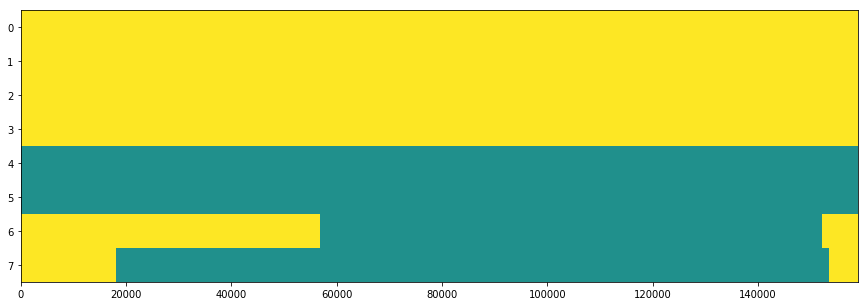

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()

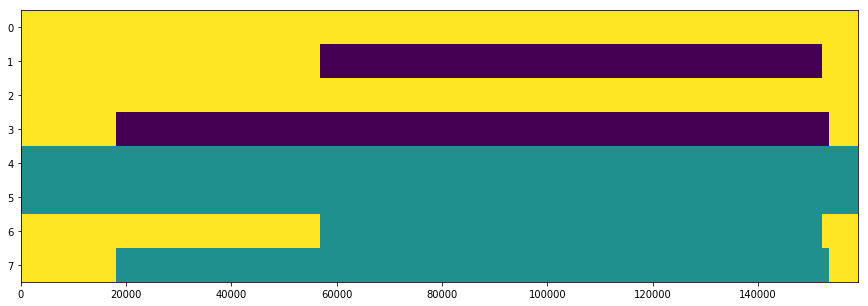

In [38]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()